In [ ]:
from google.colab import files
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip install torch_optimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 517 kB/s 


loss:tensor(0.4626, grad_fn=<MseLossBackward0>)
tensor(0.1698, grad_fn=<MseLossBackward0>)
0.16978444159030914
loss:tensor(0.3710, grad_fn=<MseLossBackward0>)
tensor(0.1038, grad_fn=<MseLossBackward0>)
0.10384824872016907
loss:tensor(0.3307, grad_fn=<MseLossBackward0>)
tensor(0.0475, grad_fn=<MseLossBackward0>)
0.04749336466193199
loss:tensor(0.1906, grad_fn=<MseLossBackward0>)
tensor(0.0272, grad_fn=<MseLossBackward0>)
0.0272146575152874
loss:tensor(0.4065, grad_fn=<MseLossBackward0>)
tensor(0.0289, grad_fn=<MseLossBackward0>)
0.028942065313458443
loss:tensor(0.2067, grad_fn=<MseLossBackward0>)
tensor(0.0811, grad_fn=<MseLossBackward0>)
0.08114262670278549
loss:tensor(0.2813, grad_fn=<MseLossBackward0>)
tensor(0.0759, grad_fn=<MseLossBackward0>)
0.07590949535369873
loss:tensor(0.2992, grad_fn=<MseLossBackward0>)
tensor(0.0513, grad_fn=<MseLossBackward0>)
0.05128977447748184
loss:tensor(0.2567, grad_fn=<MseLossBackward0>)
tensor(0.0245, grad_fn=<MseLossBackward0>)
0.024502327665686607


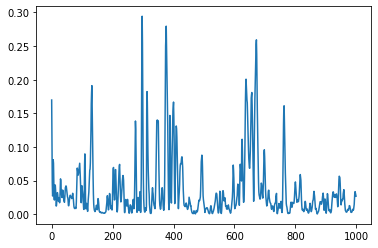

tensor(0.0269, grad_fn=<MseLossBackward0>)
***********************
Test acc with weight noise:tensor(0.0327, grad_fn=<MseLossBackward0>)


In [ ]:
from pyparsing import actions
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from random import randrange, uniform
import math
import pandas as pd
import torch.utils as utils
import operator
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
from sklearn.decomposition import PCA




class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = hidden * self.oneminusalpha + pre_activation * self.alpha
        return torch.max(torch.tensor(0.0), torch.tanh(h_new))

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            random_noise = np.random.normal(0,1)*0.1
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


'''

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.9)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.tanh(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return torch.max(torch.tensor(0.0), h_new)

    def forward(self, input, hidden=None):

        mem2 = self.lif1.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            random_noise = np.random.normal(0,1)*0.1
            pre_activation = self.input2h(input[i])
            spk2, mem2 = self.lif1(pre_activation, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2+random_noise)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
'''

class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, acts = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity, acts

class ModelAnalyzer:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader

    def plot_pred_vs_ground_truth(self):

        pred_array = []
        gt_array = []
        time_array = []

        return_arr = []

        model_input, labels = self.loader.generate_training_data()
        outputs, rnn_output = self.model(model_input)


        for i in range(60):
            pred_array.append(outputs[i, 0, 0].item())
            gt_array.append(labels[i, 0, 0].item())
            time_array.append(i)

        plt.plot(time_array, pred_array, label='pred')
        plt.plot(time_array, gt_array, label='gt')
        plt.show()

        plt.plot(time_array, pred_array, label='pred')
        plt.plot(time_array, gt_array, label='gt')
        ax = plt.gca()
        ax.set_ylim([-1.0, 1.0])
        plt.show()

    def plot_tuning_curve_hd(self, inputs, activations):
        fig, a = plt.subplots(10, 10)

        x_idx = 0
        y_idx = 0

        return_arr = []
        max_array= []

        start = True

        for i in range(100):

            hidden_activation = []
            input_value = []


            for k in range(500):
                for j in range(60):
                    hidden_activation.append(abs(activations[k, j, 0, i]))
                    input_value.append(inputs[k, j, 0, 2])

            dataset = pd.DataFrame()
            dataset['HD'] = input_value
            dataset['Activation'] = hidden_activation
            dataset['bins'] = pd.cut(dataset['HD'], 20).astype(str)
            dataset['bins_mean'] = dataset.groupby('bins')['Activation'].transform('mean')
            dataset.drop_duplicates('bins', inplace=True)
            dataset.reset_index(inplace=True)
            col = 'bins'
            df = dataset.join(
                dataset[col]
                    .str.replace("]", "", regex=False)
                    .str.replace("(", "", regex=False)
                    .str.replace(" ", "", regex=False)
                    .str.replace(",", "-", regex=False)
                    .str.replace(".0", "", regex=False)
                    .str.replace(".1", "", regex=False)
                    .str.replace(".2", "", regex=False)
                    .str.replace(".3", "", regex=False)
                    .str.replace(".4", "", regex=False)
                    .str.replace(".5", "", regex=False)
                    .str.replace(".6", "", regex=False)
                    .str.replace(".7", "", regex=False)
                    .str.replace(".8", "", regex=False)
                    .str.replace(".9", "", regex=False)
                    .str.extract(pat=r"^[$]*(\d+)[-\s$]*(\d+)$")
                    .astype("float")
                    .rename({0: f"{col}_lower", 1: f"{col}_upper"}, axis="columns")
            )
            dff = df.dropna()
            dff = dff.sort_values(by=['bins_lower'])

            return_arr.append(df['bins_mean'].to_numpy())
            max_array.append([dff['HD'].to_numpy(), dff['bins_mean'].to_numpy()])




            a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
            #a[x_idx][y_idx].set_xlim(0, 360)
            #a[x_idx][y_idx].set_ylim(0, 1.0)
            x_idx += 1
            if x_idx == 10 and start == False:
                y_idx += 1
                x_idx = 0
            start = False

        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        plt.show()
        return np.array(return_arr), np.array(max_array)


    def plot_tuning_curve_angular_velocity(self, inputs, activations):
            fig, a = plt.subplots(10, 10)

            x_idx = 0
            y_idx = 0
            return_arr = []
            max_array = []

            start = True

            for i in range(100):

                hidden_activation = []
                input_value = []

                for k in range(100):
                    for j in range(60):
                        hidden_activation.append(activations[k, j, 0, i])
                        input_value.append(inputs[k, j, 0, 3])

                dataset = pd.DataFrame()
                dataset['HD'] = np.round(input_value)
                dataset['Activation'] = hidden_activation
                dataset['bins'] = pd.cut(dataset['HD'], 20).astype(str)
                dataset['bins_mean'] = dataset.groupby('bins')['Activation'].transform('mean')
                dataset.drop_duplicates('bins', inplace=True)
                dataset.reset_index(inplace=True)
                col = 'bins'
                df = dataset.join(
                    dataset[col]
                        .str.replace("]", "", regex=False)
                        .str.replace("(", "", regex=False)
                        .str.replace(" ", "", regex=False)
                        .str.replace(",", "-", regex=False)
                        .str.replace(".0", "", regex=False)
                        .str.replace(".1", "", regex=False)
                        .str.replace(".2", "", regex=False)
                        .str.replace(".3", "", regex=False)
                        .str.replace(".4", "", regex=False)
                        .str.replace(".5", "", regex=False)
                        .str.replace(".6", "", regex=False)
                        .str.replace(".7", "", regex=False)
                        .str.replace(".8", "", regex=False)
                        .str.replace(".9", "", regex=False)
                        .str.extract(pat=r"^[$]*(\d+)[-\s$]*(\d+)$")
                        .astype("float")
                        .rename({0: f"{col}_lower", 1: f"{col}_upper"}, axis="columns")
                )
                dff = df.dropna()
                dff = dff.sort_values(by=['bins_lower'])

                return_arr.append(df['bins_mean'].to_numpy())
                max_array.append([dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy()])


                a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
                #a[x_idx][y_idx].set_xlim(0, 360)
                #a[x_idx][y_idx].set_ylim(0, 1.0)
                x_idx += 1
                if x_idx == 10 and start == False:
                    y_idx += 1
                    x_idx = 0
                start = False

            plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
            plt.show()
            return np.array(return_arr), np.array(max_array)

    def plot_joint(self, HD, activations, AV):
      fig, a = plt.subplots(10, 10)

      x_idx = 0
      y_idx = 0

      for i in range(100):

                act = []
                hd = []
                av = []

                for k in range(500):
                    for j in range(60):
                        act.append(activations[k, j, 0, i]*100.0)
                        hd.append(HD[k, j, 0, 2])
                        av.append(HD[k, j, 0, 3])

                df = pd.DataFrame({'Weekday' : np.round(np.array(hd)), 'Hour':np.round(np.array(av)), 'Value':np.array(act)})
                df['Weekday'] = pd.cut(df['Weekday'], 25)

                piv = pd.pivot_table(df, index='Hour', columns='Weekday', values='Value')
                piv = piv.fillna(0.0)


                #fig, ax = plt.subplots()
                #ax.set_aspect('equal')
                #plt.axis([0, 12, 0, 7])
                heatmap = a[x_idx][y_idx].pcolormesh(piv, cmap="seismic", shading='gouraud')

                #a[x_idx][y_idx].set_yticks(np.arange(piv.shape[0]) + 0.5, minor=False)
                a[x_idx][y_idx].set_xticks(np.arange(piv.shape[1]) + 0.5, minor=False)
                a[x_idx][y_idx].set_xticklabels(piv.columns, minor=False)
                #a[x_idx][y_idx].set_yticklabels(piv.index, minor=False)
                #a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
                #a[x_idx][y_idx].set_xlim(0, 360)
                #a[x_idx][y_idx].set_ylim(0, 1.0)
                x_idx += 1
                if x_idx == 10 and start == False:
                    y_idx += 1
                    x_idx = 0
                start = False

      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.show()



    def get_delta(self, idx, idy, maxes):
      ##get 2d array for two idxs
      ##find max and corresponding value
      ##delta for corresponding values
      pref1_x = maxes[idx, 0, :].reshape((-1, 1))
      pref1_y = maxes[idx, 1, :].reshape((-1, 1))

      pref2_x = maxes[idy, 0, :].reshape((-1, 1))
      pref2_y = maxes[idy, 1, :].reshape((-1, 1))

      indices1 = np.where(pref1_y == pref1_y.max())
      indices2 = np.where(pref2_y == pref2_y.max())

      if len(np.atleast_1d(pref1_x[indices1])) == 1 and len(np.atleast_1d(pref2_x[indices2])) == 1:
        return (pref1_x[indices1][0] - pref2_x[indices2][0])
      else:
        return None



    def plot_pref(self, model, maxes):
      delta_po = None
      weights = model.rnn.h2h.weight.detach().numpy()
      weight_avg = []
      delta_pref_or = []
      for i in range(100):
        for j in range(100):
          weight = weights[i][j]
          delta_po = self.get_delta(i, j, maxes)
          if delta_po != None:
            weight_avg.append(weight)
            delta_pref_or.append(delta_po)

      dataset = pd.DataFrame()
      dataset['pref'] = delta_pref_or
      dataset['weight'] = weight_avg
      dataset['bins'] = pd.cut(dataset['pref'], 200).astype(str)
      dataset['bins_mean'] = dataset.groupby('bins')['weight'].transform('mean')
      #dataset = dataset.groupby('weight').mean()
      #dataset.drop_duplicates('bins', inplace=True)
      #dataset.reset_index(inplace=True)
      y_mean = [np.mean(dataset['bins_mean'].to_numpy())]*len(dataset['pref'].to_numpy())

      #plt.scatter(dataset['pref'].to_numpy(), dataset['bins_mean'].to_numpy())
      #plt.plot(dataset['pref'].to_numpy(), y_mean)
      #plt.show()
      x = dataset['pref'].to_numpy()
      y = dataset['bins_mean'].to_numpy()


      fig, ax = plt.subplots()
      sns.regplot(x=x, y=y, ax=ax, lowess=True)
      ax.set_xlim(-180, 180)
      plt.show()


    def plot_pca_bumps(self, X):
      for i in range(60):
        print(X.shape)
        X_new = X[0, i, :, :]
        pca = PCA(n_components=2)
        Xt = pca.fit_transform(X_new)
        plot = plt.scatter(Xt[:,0], Xt[:,1])
        plt.show()


    def plot_pca(self, X):
        print(X.shape)
        X_new = X[:, 0, 0, :]
        pca = PCA(n_components=2)
        Xt = pca.fit_transform(X_new)
        plot = plt.scatter(Xt[:,0], Xt[:,1])
        plt.show()


    def plot_conn(self, model):
      weight_array = np.zeros((100, 100))

      weights = model.rnn.h2h.weight.detach().numpy().T

      for i in range(100):
        for j in range(100):
          weight_array[i, j] = weights[i][j]

      weight_array = 2.*(weight_array - np.min(weight_array))/np.ptp(weight_array)-1

      plt.pcolormesh(np.array(np.array(weight_array).reshape((100, 100))), cmap='bwr')
      plt.show()


class ModelTrainer:
    import torch
    import numpy as np

    def __init__(self, tau: object, dt: object, x_0: object, W: object, seed: object) -> object:
        self.seed = seed
        self.torch.manual_seed(seed)
        self.np.random.seed(seed)
        self.x_0 = x_0
        self.dt = dt
        self.tau = tau
        self.W = W
        self.hidden_activations = []
        self.input_activations = []
        self.train_loader = None

    def get_train_loader(self):

        if self.train_loader == None:
            print('WARNING: loader is None')

        return self.train_loader

    def compute_angular_velocity(self, x, prev_angular_velocity):
        return (0.03 * x) + (0.8 * prev_angular_velocity)  ##convert 0.03 rad/s to deg/s using 180/pi

    def load_training_data(self):
        train_x = np.load('/home/chris/Desktop/data_x.npy').astype(float)
        train_y = np.load('/home/chris/Desktop/data_x.npy').astype(float)
        dataset = utils.data.TensorDataset(train_x, train_y)
        dataloader = utils.data.DataLoader(dataset)
        print(train_x)
        print(train_y)

        return dataloader

    def generate_training_data(self):

        final_array1 = np.zeros((60, 8, 3))
        final_array2 = np.zeros((60, 8, 4))

        for i in range(8):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03
          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []


          for step in range(0, time_steps):


              x = np.random.normal(0,1)


              if step < 30:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(theta_initial))
                  input_values.append(np.cos(theta_initial))
              else:
                  angular_velocity = self.compute_angular_velocity(x, prev_angular_velocity)
                  prev_angular_velocity = angular_velocity
                  input_values.append(angular_velocity)

                  input_values.append(0.0)
                  input_values.append(0.0)

                  theta = theta + angular_velocity


              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 8, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 8, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y

    def generate_training_data_with_noise(self):

        final_array1 = np.zeros((60, 8, 3))
        final_array2 = np.zeros((60, 8, 4))

        for i in range(8):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03
          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []


          for step in range(0, time_steps):


              x = np.random.normal(0,1)
              random_noise = np.random.normal(0,1)*0.1


              if step < 30:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(theta_initial))
                  input_values.append(np.cos(theta_initial))
              else:
                  angular_velocity = self.compute_angular_velocity(x, prev_angular_velocity)
                  prev_angular_velocity = angular_velocity
                  input_values.append(angular_velocity + random_noise)

                  input_values.append(0.0)
                  input_values.append(0.0)

                  theta = theta + angular_velocity


              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 8, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 8, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y


    def generate_training_data_one_location(self):

        final_array1 = np.zeros((60, 8, 3))
        final_array2 = np.zeros((60, 8, 4))

        for i in range(8):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03

          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []


          for step in range(0, time_steps):


              x = np.random.normal(0,1)


              if step < 30:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(np.radians(theta)))
                  input_values.append(np.cos(np.radians(theta)))
                  theta = np.radians(0.0)
              else:
                  angular_velocity = 0.0
                  prev_angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(np.radians(theta)))
                  input_values.append(np.cos(np.radians(theta)))



              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          #plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 8, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 8, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y


    def test_data_size(self, dataset):
        batch_size = 10
        seq_len = 20  # sequence length
        input_size = 3  # input dimension

        # Make network
        rnn = RNN(input_size=input_size, hidden_size=100, output_size=2, tau=250, dt=25)

        # Run the sequence through the network
        out, rnn_output = rnn(dataset)

        print('Input of shape (SeqLen, BatchSize, InputDim)=', dataset.shape)
        print('Output of shape (SeqLen, BatchSize, Neuron)=', out.shape)

    def get_model(self):
        return RNNNet(input_size=3, hidden_size=100, output_size=2, tau=250, dt=25)

    def get_inputs_and_activations(self, model):

        av = []

        for i in range(500): #5000 for snn joint tuning plots

            model_input, labels = self.generate_training_data()

            self.input_activations.append(labels.detach().numpy())

            outputs, rnn_output, acts = model(model_input)

            self.hidden_activations.append(acts.detach().numpy())
            av.append(model_input.detach().numpy()[:,:,0])



        return np.array(self.input_activations), np.array(self.hidden_activations), np.array(av)

    def get_inputs_and_activations_one_location(self, model):

        av = []

        for i in range(5000): #5000 for snn joint tuning plots

            model_input, labels = self.generate_training_data_one_location(i)

            self.input_activations.append(labels.detach().numpy())

            outputs, rnn_output, acts = model(model_input)

            self.hidden_activations.append(rnn_output.detach().numpy())
            av.append(model_input.detach().numpy()[:,:,0])



        return np.array(self.input_activations), np.array(self.hidden_activations), np.array(av)

    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)

    def get_test_acc(self, model):
      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data_one_location()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output, acts = model(model_inputt)
      loss = criterion(outputs, labels)
      print(str(loss))
      return float(loss.detach().numpy())

    def train_model(self, model):
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()

        loss_array = []
        iterations_array = []
        itr_counter = 0
        norm_array = []
        total_norm = 0
        model_analyzer = ModelAnalyzer(model, model_trainer)
        test_acc = []




        for epoch in range(1000):
            model_inputt, labelss = self.generate_training_data()

            model.train()

            labels = labelss[: , :, 0:2]

            optimizer.zero_grad()

            outputs, rnn_output, acts = model(model_inputt)

            loss = criterion(outputs, labels)

            loss.backward()
            #self.plot_grad_flow(model.named_parameters())



            norm_array.append(total_norm)

            optimizer.step()

            print('loss:' + str(loss))
            acc = self.get_test_acc(model)
            test_acc.append(acc)
            print(acc)


            loss_array.append(loss)
            iterations_array.append(epoch)
            itr_counter += 1

        plt.plot(iterations_array, test_acc)
        plt.show()

        return model

    def test_with_weight_noise(self, model):

      with torch.no_grad():
        for param in model.parameters():
          param.add_(torch.randn(param.size()) * 0.1)

      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data_one_location()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output, acts = model(model_inputt)
      loss = criterion(outputs, labels)
      print('Test acc with weight noise:' + str(loss))

    def test_with_input_noise(self, model):
      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data_with_noise()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output = model(model_inputt)
      loss = criterion(outputs, labels)
      print('Test acc with input noise:' + str(loss))


    def run(self):
        model = self.get_model()
        model = self.train_model(model)
        self.get_test_acc(model)
        print('***********************')
        self.test_with_weight_noise(model)
        return model

model_trainer = ModelTrainer(tau=250.0, dt=25.0, x_0=1.0, W=2.0, seed=3) #3
model = model_trainer.run()
#model = model_trainer.get_test_acc(model)
#loader = model_trainer.get_train_loader()

#model_analyzer = ModelAnalyzer(model, model_trainer)


#inputs, activations, av = model_trainer.get_inputs_and_activations_one_location(model.eval())

#model_analyzer.plot_pred_vs_ground_truth()
#HD_activations, maxes = model_analyzer.plot_tuning_curve_hd(inputs, activations)
#AV_activations, maxes = model_analyzer.plot_tuning_curve_angular_velocity(inputs, activations)
#model_analyzer.plot_joint(inputs, av, activations)
#model_analyzer.plot_conn(model)
#model_analyzer.plot_pref(model, maxes)
#model_analyzer.plot_pca(activations)

In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import snntorch as snn
from snntorch import surrogate
beta = 0.5  # neuron decay rate
spike_grad = surrogate.fast_sigmoid()

In [ ]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate

num_steps = 25 # number of time steps
batch_size = 1
beta = 0.5  # neuron decay rate
spike_grad = surrogate.fast_sigmoid()

net = nn.Sequential(
      nn.Conv2d(1, 8, 5),
      nn.MaxPool2d(2),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad),
      nn.Conv2d(8, 16, 5),
      nn.MaxPool2d(2),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad),
      nn.Flatten(),
      nn.Linear(16 * 4 * 4, 10),
      snn.Leaky(beta=beta, init_hidden=True, spike_grad=spike_grad, output=True)
      )

# random input data
data_in = torch.rand(num_steps, batch_size, 1, 28, 28)

spike_recording = []

for step in range(num_steps):
    spike, state = net(data_in[step])
    spike_recording.append(spike)

loss:tensor(0.4652, grad_fn=<MseLossBackward0>)


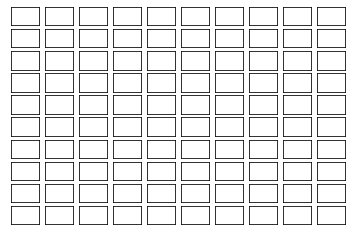

(60, 100)
(60, 2)


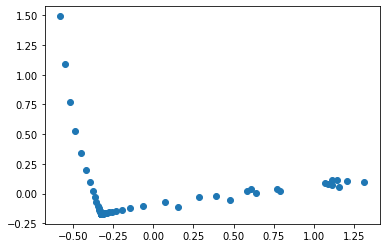

loss:tensor(0.4040, grad_fn=<MseLossBackward0>)
loss:tensor(0.3335, grad_fn=<MseLossBackward0>)
loss:tensor(0.2672, grad_fn=<MseLossBackward0>)
loss:tensor(0.1792, grad_fn=<MseLossBackward0>)
loss:tensor(0.2735, grad_fn=<MseLossBackward0>)
loss:tensor(0.4288, grad_fn=<MseLossBackward0>)
loss:tensor(0.1508, grad_fn=<MseLossBackward0>)
loss:tensor(0.1434, grad_fn=<MseLossBackward0>)
loss:tensor(0.2435, grad_fn=<MseLossBackward0>)
loss:tensor(0.2245, grad_fn=<MseLossBackward0>)
loss:tensor(0.1159, grad_fn=<MseLossBackward0>)
loss:tensor(0.1734, grad_fn=<MseLossBackward0>)
loss:tensor(0.1993, grad_fn=<MseLossBackward0>)
loss:tensor(0.2073, grad_fn=<MseLossBackward0>)
loss:tensor(0.1325, grad_fn=<MseLossBackward0>)
loss:tensor(0.1147, grad_fn=<MseLossBackward0>)
loss:tensor(0.1431, grad_fn=<MseLossBackward0>)
loss:tensor(0.0981, grad_fn=<MseLossBackward0>)
loss:tensor(0.1458, grad_fn=<MseLossBackward0>)
loss:tensor(0.1277, grad_fn=<MseLossBackward0>)
loss:tensor(0.1072, grad_fn=<MseLossBack

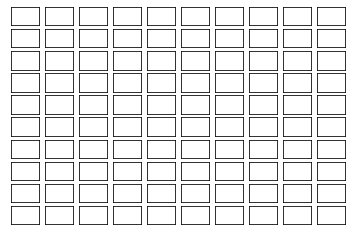

(60, 100)
(60, 2)


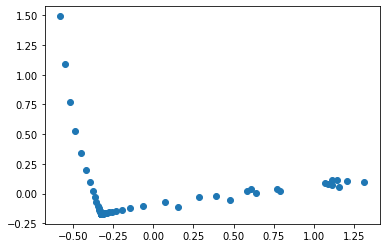

loss:tensor(0.1096, grad_fn=<MseLossBackward0>)
loss:tensor(0.0945, grad_fn=<MseLossBackward0>)
loss:tensor(0.1164, grad_fn=<MseLossBackward0>)
loss:tensor(0.1601, grad_fn=<MseLossBackward0>)
loss:tensor(0.1275, grad_fn=<MseLossBackward0>)
loss:tensor(0.1455, grad_fn=<MseLossBackward0>)
loss:tensor(0.0623, grad_fn=<MseLossBackward0>)
loss:tensor(0.1369, grad_fn=<MseLossBackward0>)
loss:tensor(0.0566, grad_fn=<MseLossBackward0>)
loss:tensor(0.1046, grad_fn=<MseLossBackward0>)
loss:tensor(0.0994, grad_fn=<MseLossBackward0>)
loss:tensor(0.1287, grad_fn=<MseLossBackward0>)
loss:tensor(0.0775, grad_fn=<MseLossBackward0>)
loss:tensor(0.1232, grad_fn=<MseLossBackward0>)
loss:tensor(0.1637, grad_fn=<MseLossBackward0>)
loss:tensor(0.0715, grad_fn=<MseLossBackward0>)
loss:tensor(0.0652, grad_fn=<MseLossBackward0>)
loss:tensor(0.0768, grad_fn=<MseLossBackward0>)
loss:tensor(0.0768, grad_fn=<MseLossBackward0>)
loss:tensor(0.1009, grad_fn=<MseLossBackward0>)
loss:tensor(0.1224, grad_fn=<MseLossBack

KeyboardInterrupt: ignored

In [ ]:
from pyparsing import actions
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from random import randrange, uniform
import math
import pandas as pd
import torch.utils as utils
import operator
import seaborn as sns
import random

import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
from sklearn.decomposition import PCA


class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = hidden * self.oneminusalpha + pre_activation * self.alpha
        return torch.max(torch.tensor(0.0), torch.tanh(h_new))

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


'''

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.lif1 = snn.Leaky(beta=0.9)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.tanh(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return torch.max(torch.tensor(0.0), h_new)

    def forward(self, input, hidden=None):

        mem2 = self.lif1.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            random_noise = np.random.normal(0,1)
            pre_activation = self.input2h(input[i])
            spk2, mem2 = self.lif1(pre_activation, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2+random_noise)
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

'''


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, acts = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity, acts

class ModelAnalyzer:
    def __init__(self, model, loader):
        self.model = model
        self.loader = loader

    def plot_pred_vs_ground_truth(self):

        pred_array = []
        gt_array = []
        time_array = []

        return_arr = []

        model_input, labels = self.loader.generate_training_data()
        outputs, rnn_output = self.model(model_input)


        for i in range(60):
            pred_array.append(outputs[i, 0, 0].item())
            gt_array.append(labels[i, 0, 0].item())
            time_array.append(i)

        plt.plot(time_array, pred_array, label='pred')
        plt.plot(time_array, gt_array, label='gt')
        plt.show()

        plt.plot(time_array, pred_array, label='pred')
        plt.plot(time_array, gt_array, label='gt')
        ax = plt.gca()
        ax.set_ylim([-1.0, 1.0])
        plt.show()

    def plot_tuning_curve_hd(self, inputs, activations):
        fig, a = plt.subplots(10, 10)

        x_idx = 0
        y_idx = 0

        return_arr = []
        max_array= []

        start = True

        for i in range(100):

            hidden_activation = []
            input_value = []


            for k in range(2000):
                for j in range(60):
                    hidden_activation.append(abs(activations[k, j, 0, i]))
                    input_value.append(inputs[k, j, 0, 2])

            dataset = pd.DataFrame()
            dataset['HD'] = input_value
            dataset['Activation'] = hidden_activation
            dataset['bins'] = pd.cut(dataset['HD'], 20).astype(str)
            dataset['bins_mean'] = dataset.groupby('bins')['Activation'].transform('mean')
            dataset.drop_duplicates('bins', inplace=True)
            dataset.reset_index(inplace=True)
            col = 'bins'
            df = dataset.join(
                dataset[col]
                    .str.replace("]", "", regex=False)
                    .str.replace("(", "", regex=False)
                    .str.replace(" ", "", regex=False)
                    .str.replace(",", "-", regex=False)
                    .str.replace(".0", "", regex=False)
                    .str.replace(".1", "", regex=False)
                    .str.replace(".2", "", regex=False)
                    .str.replace(".3", "", regex=False)
                    .str.replace(".4", "", regex=False)
                    .str.replace(".5", "", regex=False)
                    .str.replace(".6", "", regex=False)
                    .str.replace(".7", "", regex=False)
                    .str.replace(".8", "", regex=False)
                    .str.replace(".9", "", regex=False)
                    .str.extract(pat=r"^[$]*(\d+)[-\s$]*(\d+)$")
                    .astype("float")
                    .rename({0: f"{col}_lower", 1: f"{col}_upper"}, axis="columns")
            )
            dff = df.dropna()
            dff = dff.sort_values(by=['bins_lower'])

            return_arr.append(df['bins_mean'].to_numpy())
            max_array.append([dff['HD'].to_numpy(), dff['bins_mean'].to_numpy()])




            a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
            #a[x_idx][y_idx].set_xlim(0, 360)
            #a[x_idx][y_idx].set_ylim(0, 1.0)
            x_idx += 1
            if x_idx == 10 and start == False:
                y_idx += 1
                x_idx = 0
            start = False

        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        plt.show()
        return np.array(return_arr), np.array(max_array)


    def plot_tuning_curve_angular_velocity(self, inputs, activations):
            fig, a = plt.subplots(10, 10)

            x_idx = 0
            y_idx = 0
            return_arr = []
            max_array = []

            start = True

            for i in range(100):

                hidden_activation = []
                input_value = []

                for k in range(100):
                    for j in range(60):
                        hidden_activation.append(activations[k, j, 0, i])
                        input_value.append(inputs[k, j, 0, 3])

                dataset = pd.DataFrame()
                dataset['HD'] = np.round(input_value)
                dataset['Activation'] = hidden_activation
                dataset['bins'] = pd.cut(dataset['HD'], 20).astype(str)
                dataset['bins_mean'] = dataset.groupby('bins')['Activation'].transform('mean')
                dataset.drop_duplicates('bins', inplace=True)
                dataset.reset_index(inplace=True)
                col = 'bins'
                df = dataset.join(
                    dataset[col]
                        .str.replace("]", "", regex=False)
                        .str.replace("(", "", regex=False)
                        .str.replace(" ", "", regex=False)
                        .str.replace(",", "-", regex=False)
                        .str.replace(".0", "", regex=False)
                        .str.replace(".1", "", regex=False)
                        .str.replace(".2", "", regex=False)
                        .str.replace(".3", "", regex=False)
                        .str.replace(".4", "", regex=False)
                        .str.replace(".5", "", regex=False)
                        .str.replace(".6", "", regex=False)
                        .str.replace(".7", "", regex=False)
                        .str.replace(".8", "", regex=False)
                        .str.replace(".9", "", regex=False)
                        .str.extract(pat=r"^[$]*(\d+)[-\s$]*(\d+)$")
                        .astype("float")
                        .rename({0: f"{col}_lower", 1: f"{col}_upper"}, axis="columns")
                )
                dff = df.dropna()
                dff = dff.sort_values(by=['bins_lower'])

                return_arr.append(df['bins_mean'].to_numpy())
                max_array.append([dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy()])


                a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
                #a[x_idx][y_idx].set_xlim(0, 360)
                #a[x_idx][y_idx].set_ylim(0, 1.0)
                x_idx += 1
                if x_idx == 10 and start == False:
                    y_idx += 1
                    x_idx = 0
                start = False

            plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
            plt.show()
            return np.array(return_arr), np.array(max_array)

    def plot_joint(self, HD, activations, AV):
      fig, a = plt.subplots(10, 10)

      x_idx = 0
      y_idx = 0

      for i in range(100):

                act = []
                hd = []
                av = []

                for k in range(2000):
                    for j in range(60):
                        act.append(activations[k, j, 0, i]*100.0)
                        hd.append(HD[k, j, 0, 2])
                        av.append(HD[k, j, 0, 3])

                df = pd.DataFrame({'Weekday' : np.round(np.array(hd)), 'Hour':np.round(np.array(av)), 'Value':np.array(act)})
                df['Weekday'] = pd.cut(df['Weekday'], 25)

                piv = pd.pivot_table(df, index='Hour', columns='Weekday', values='Value')
                piv = piv.fillna(0.0)


                #fig, ax = plt.subplots()
                #ax.set_aspect('equal')
                #plt.axis([0, 12, 0, 7])
                heatmap = a[x_idx][y_idx].pcolormesh(piv, cmap="seismic", shading='gouraud')

                #a[x_idx][y_idx].set_yticks(np.arange(piv.shape[0]) + 0.5, minor=False)
                a[x_idx][y_idx].set_xticks(np.arange(piv.shape[1]) + 0.5, minor=False)
                a[x_idx][y_idx].set_xticklabels(piv.columns, minor=False)
                #a[x_idx][y_idx].set_yticklabels(piv.index, minor=False)
                #a[x_idx][y_idx].plot(dff['bins_lower'].to_numpy(), dff['bins_mean'].to_numpy())
                #a[x_idx][y_idx].set_xlim(0, 360)
                #a[x_idx][y_idx].set_ylim(0, 1.0)
                x_idx += 1
                if x_idx == 10 and start == False:
                    y_idx += 1
                    x_idx = 0
                start = False

      plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
      plt.show()



    def get_delta(self, idx, idy, maxes):
      ##get 2d array for two idxs
      ##find max and corresponding value
      ##delta for corresponding values
      pref1_x = maxes[idx, 0, :].reshape((-1, 1))
      pref1_y = maxes[idx, 1, :].reshape((-1, 1))

      pref2_x = maxes[idy, 0, :].reshape((-1, 1))
      pref2_y = maxes[idy, 1, :].reshape((-1, 1))

      indices1 = np.where(pref1_y == pref1_y.max())
      indices2 = np.where(pref2_y == pref2_y.max())

      if len(np.atleast_1d(pref1_x[indices1])) == 1 and len(np.atleast_1d(pref2_x[indices2])) == 1:
        return (pref1_x[indices1][0] - pref2_x[indices2][0])
      else:
        return None



    def plot_pref(self, model, maxes):
      delta_po = None
      weights = model.rnn.h2h.weight.detach().numpy()
      weight_avg = []
      delta_pref_or = []
      for i in range(100):
        for j in range(100):
          weight = weights[i][j]
          delta_po = self.get_delta(i, j, maxes)
          if delta_po != None:
            weight_avg.append(weight)
            delta_pref_or.append(delta_po)

      dataset = pd.DataFrame()
      dataset['pref'] = delta_pref_or
      dataset['weight'] = weight_avg
      dataset['bins'] = pd.cut(dataset['pref'], 200).astype(str)
      dataset['bins_mean'] = dataset.groupby('bins')['weight'].transform('mean')
      #dataset = dataset.groupby('weight').mean()
      #dataset.drop_duplicates('bins', inplace=True)
      #dataset.reset_index(inplace=True)
      y_mean = [np.mean(dataset['bins_mean'].to_numpy())]*len(dataset['pref'].to_numpy())

      #plt.scatter(dataset['pref'].to_numpy(), dataset['bins_mean'].to_numpy())
      #plt.plot(dataset['pref'].to_numpy(), y_mean)
      #plt.show()
      x = dataset['pref'].to_numpy()
      y = dataset['bins_mean'].to_numpy()


      fig, ax = plt.subplots()
      sns.regplot(x=x, y=y, ax=ax, lowess=True)
      ax.set_xlim(-180, 180)
      plt.show()


    def plot_pca_bumps(self, X): ##dont recalc PCA for each time point - use same and then loop through or vectorize
        X_new = X[0, :, 0, :]
        print(X_new.shape)
        pca = PCA(n_components=2)
        Xt = pca.fit_transform(X_new)
        print(Xt.shape)
        plot = plt.scatter(Xt[:,0], Xt[:,1])
        plt.show()


    def plot_pca(self, X):
        print(X.shape)
        X_new = X[:, 0, 0, :]
        pca = PCA(n_components=2)
        Xt = pca.fit_transform(X_new)
        plot = plt.scatter(Xt[:,0], Xt[:,1])
        plt.show()


    def plot_conn(self, model):
      weight_array = np.zeros((100, 100))

      weights = model.rnn.h2h.weight.detach().numpy().T

      for i in range(100):
        for j in range(100):
          weight_array[i, j] = weights[i][j]

      weight_array = 2.*(weight_array - np.min(weight_array))/np.ptp(weight_array)-1

      plt.pcolormesh(np.array(np.array(weight_array).reshape((100, 100))), cmap='bwr')
      plt.show()


class ModelTrainer:
    import torch
    import numpy as np

    def __init__(self, tau: object, dt: object, x_0: object, W: object, seed: object) -> object:
        self.seed = seed
        self.torch.manual_seed(seed)
        self.np.random.seed(seed)
        self.x_0 = x_0
        self.dt = dt
        self.tau = tau
        self.W = W
        self.hidden_activations = []
        self.input_activations = []
        self.train_loader = None

    def get_train_loader(self):

        if self.train_loader == None:
            print('WARNING: loader is None')

        return self.train_loader

    def compute_angular_velocity(self, x, prev_angular_velocity):
        return (0.03 * x) + (0.8 * prev_angular_velocity)  ##convert 0.03 rad/s to deg/s using 180/pi

    def load_training_data(self):
        train_x = np.load('/home/chris/Desktop/data_x.npy').astype(float)
        train_y = np.load('/home/chris/Desktop/data_x.npy').astype(float)
        dataset = utils.data.TensorDataset(train_x, train_y)
        dataloader = utils.data.DataLoader(dataset)
        print(train_x)
        print(train_y)

        return dataloader

    def generate_training_data(self):

        final_array1 = np.zeros((60, 8, 3))
        final_array2 = np.zeros((60, 8, 4))

        for i in range(8):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03
          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []


          for step in range(0, time_steps):


              x = np.random.normal(0,1)


              if step < 30:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(theta_initial))
                  input_values.append(np.cos(theta_initial))
              else:
                  angular_velocity = self.compute_angular_velocity(x, prev_angular_velocity)
                  prev_angular_velocity = angular_velocity
                  input_values.append(angular_velocity)

                  input_values.append(0.0)
                  input_values.append(0.0)

                  theta = theta + angular_velocity


              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 8, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 8, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y

    def generate_training_data_with_noise(self):

        final_array1 = np.zeros((60, 8, 3))
        final_array2 = np.zeros((60, 8, 4))

        for i in range(8):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03
          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []


          for step in range(0, time_steps):


              x = np.random.normal(0,1)
              random_noise = np.random.normal(0,1)*0.1


              if step < 30:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(theta_initial))
                  input_values.append(np.cos(theta_initial))
              else:
                  angular_velocity = self.compute_angular_velocity(x, prev_angular_velocity)
                  prev_angular_velocity = angular_velocity
                  input_values.append(angular_velocity + random_noise)

                  input_values.append(0.0)
                  input_values.append(0.0)

                  theta = theta + angular_velocity


              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 8, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 8, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y


    def generate_training_data_one_location(self, idx):

        final_array1 = np.zeros((60, 9, 3))
        final_array2 = np.zeros((60, 9, 4))

        for i in range(9):
          time_steps = 60
          prev_angular_velocity = np.random.normal(0,1) * 0.03
          angular_velocity = np.random.normal(0,1) * 0.03

          theta = np.radians(uniform(0, 360))
          theta_initial = theta

          theta_array = []
          time_array = []

          input_values = []
          input_array = []

          output_values = []
          output_array = []

          vels = [1.3, .12, 1.2, .56, 1.9, 1.88, 2.1, 1,1]
          vidx = 0


          for step in range(0, time_steps):


              x = np.random.normal(0,1)

              if vidx == 8:
                vidx = 0
              else:
                vidx = vidx + 1


              if step < 30 or step > 45:
                  prev_angular_velocity = angular_velocity = 0.0
                  input_values.append(0.0)

                  input_values.append(np.sin(np.radians(0.0)))
                  input_values.append(np.cos(np.radians(0.0)))
                  theta = np.radians(0.0)
              else:
                  angular_velocity = 0.0
                  prev_angular_velocity = 0.0
                  input_values.append(int(vels[vidx]))

                  input_values.append(np.sin(np.radians(0.0)))
                  input_values.append(np.cos(np.radians(0.0)))

                  theta = 0.0

              output_values.append(np.sin(theta))
              output_values.append(np.cos(theta))
              output_values.append(np.degrees(theta))
              output_values.append(angular_velocity*(180.0/math.pi))

              #theta_initial = theta

              theta_array.append(np.degrees(theta))
              time_array.append(step)

              input_array.append(input_values)
              output_array.append(output_values)

              input_values = []
              output_values = []

          #print(input_array)
          #print(output_array)
          input_arrayy = np.array(input_array).reshape((60, 1, 3))
          output_arrayy = np.array(output_array).reshape((60, 1, 4))


          #plt.plot(time_array, theta_array)
          plt.show()

          #data_pd = pd.DataFrame(input_array)
          #data_pd.columns = ['Sin Theta0', 'Cos Theta0', 'w', 'Sin Theta', 'Cos Theta']

          #print(data_pd.head())

          #plt.plot(time_array, data_pd[['Sin Theta']].to_numpy())
          #plt.plot(time_array, data_pd[['Cos Theta']].to_numpy())
          #plt.show()
          final_array1[:, i, :] = input_arrayy.reshape((60, 3))
          final_array2[:, i, :] = output_arrayy.reshape((60, 4))


        train_x = torch.Tensor(np.array(final_array1).reshape((60, 9, 3)))
        train_y = torch.Tensor(np.array(final_array2).reshape((60, 9, 4)))


        #dataset = utils.data.TensorDataset(train_x, train_y)
        #dataloader = utils.data.DataLoader(dataset)

        return train_x, train_y


    def test_data_size(self, dataset):
        batch_size = 10
        seq_len = 20  # sequence length
        input_size = 3  # input dimension

        # Make network
        rnn = RNN(input_size=input_size, hidden_size=100, output_size=2, tau=250, dt=25)

        # Run the sequence through the network
        out, rnn_output = rnn(dataset)

        print('Input of shape (SeqLen, BatchSize, InputDim)=', dataset.shape)
        print('Output of shape (SeqLen, BatchSize, Neuron)=', out.shape)

    def get_model(self):
        return RNNNet(input_size=3, hidden_size=100, output_size=2, tau=250, dt=25)

    def get_inputs_and_activations(self, model):

        av = []

        for i in range(2000): #5000 for snn joint tuning plots

            model_input, labels = self.generate_training_data()

            self.input_activations.append(labels.detach().numpy())

            outputs, rnn_output, acts = model(model_input)

            self.hidden_activations.append(rnn_output.detach().numpy())
            av.append(model_input.detach().numpy()[:,:,0])



        return np.array(self.input_activations), np.array(self.hidden_activations), np.array(av)

    def get_inputs_and_activations_one_location(self, model):

        av = []

        for i in range(5000): #5000 for snn joint tuning plots

            model_input, labels = self.generate_training_data_one_location(i)

            self.input_activations.append(labels.detach().numpy())

            outputs, rnn_output, acts = model(model_input)

            self.hidden_activations.append(rnn_output.detach().numpy())
            av.append(model_input.detach().numpy()[:,:,0])



        return np.array(self.input_activations), np.array(self.hidden_activations), np.array(av)

    def plot_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if(p.requires_grad) and ("bias" not in n):
                layers.append(n)
                ave_grads.append(p.grad.abs().mean())
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
        plt.xlabel("Layers")
        plt.ylabel("average gradient")
        plt.title("Gradient flow")
        plt.grid(True)

    def train_model(self, model):
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.MSELoss()

        loss_array = []
        iterations_array = []
        itr_counter = 0
        norm_array = []
        total_norm = 0
        model_analyzer = ModelAnalyzer(model, model_trainer)




        for epoch in range(2500):
            model_inputt, labelss = self.generate_training_data()

            model.train()

            labels = labelss[: , :, 0:2]

            optimizer.zero_grad()

            outputs, rnn_output, acts = model(model_inputt)

            loss = criterion(outputs, labels)

            loss.backward()
            #self.plot_grad_flow(model.named_parameters())



            norm_array.append(total_norm)

            optimizer.step()

            print('loss:' + str(loss))

            if epoch % 100 == 0:
              inputs, activations, av = self.get_inputs_and_activations_one_location(model.eval())

              HD_activations, maxes = model_analyzer.plot_tuning_curve_hd(inputs, activations)

              model_analyzer.plot_pca_bumps(activations)


            loss_array.append(loss)
            iterations_array.append(epoch)
            itr_counter += 1

        plt.plot(iterations_array, norm_array)
        plt.show()

        return model

    def get_test_acc(self, model):
      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output = model(model_inputt)
      loss = criterion(outputs, labels)
      print('Test acc:' + str(loss))

    def test_with_weight_noise(self, model):

      with torch.no_grad():
        for param in model.parameters():
          param.add_(torch.randn(param.size()) * 0.1)

      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output = model(model_inputt)
      loss = criterion(outputs, labels)
      print('Test acc with weight noise:' + str(loss))

    def test_with_input_noise(self, model):
      criterion = nn.MSELoss()
      loss_array = []
      model_inputt, labelss = self.generate_training_data_with_noise()
      model.eval()
      labels = labelss[: , :, 0:2]
      outputs, rnn_output = model(model_inputt)
      loss = criterion(outputs, labels)
      print('Test acc with input noise:' + str(loss))


    def run(self):
        model = self.get_model()
        model = self.train_model(model)
        return model

model_trainer = ModelTrainer(tau=250.0, dt=25.0, x_0=1.0, W=2.0, seed=3) #3
model = model_trainer.run()
model = model_trainer.get_test_acc(model)
#loader = model_trainer.get_train_loader()

model_analyzer = ModelAnalyzer(model, model_trainer)


inputs, activations, av = model_trainer.get_inputs_and_activations_one_location(model.eval())

#model_analyzer.plot_pred_vs_ground_truth()
#HD_activations, maxes = model_analyzer.plot_tuning_curve_hd(inputs, activations)
#AV_activations, maxes = model_analyzer.plot_tuning_curve_angular_velocity(inputs, activations)
#model_analyzer.plot_joint(inputs, av, activations)
#model_analyzer.plot_conn(model)
#model_analyzer.plot_pref(model, maxes)
model_analyzer.plot_pca_bumps(activations)

In [ ]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 275 kB/s 


In [ ]:
import snntorch as snn
from snntorch import surrogate
beta = 0.5  # neuron decay rate
spike_grad = surrogate.fast_sigmoid()

In [ ]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.

    Usage: Plug this function in Trainer class after loss.backwards() as
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")

In [ ]:
loss = self.criterion(outputs, labels)
loss.backward()
plot_grad_flow(model.named_parameters())